In [1]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer

DEBUG = False

env = TictactoeEnv()
Turns = np.array(['X','O'])

# Question 1
In this section, you will study whether Q-learning can learn to play Tic Tac Toe by playing against
Opt(eps_opt) for some eps_opt ∈ [0, 1]. To do so, implement the Q-learning algorithm. To check the algorithm,
run a Q-learning agent, with a fixed and arbitrary eps ∈ [0, 1), against Opt(0.5) for 20’000 games – switch
the 1st player after every game.
Question 1. Plot average reward for every 250 games during training – i.e. after the 50th game, plot
the average reward of the first 250 games, after the 100th game, plot the average reward of games 51 to
100, etc. Does the agent learn to play Tic Tac Toe?
Expected answer: A figure of average reward over time (caption length < 50 words). Specify your choice
of eps.

In [2]:
def grid_to_string(bts, is_buffer = True):
        _grid = np.reshape(np.frombuffer(bts),(3,3)) if is_buffer else bts
        str_rep = ''
        value2player = {0: '-', 1: 'X', -1: 'O'}
        for i in range(3):
            str_rep +='|'
            for j in range(3):
                str_rep += value2player[int(_grid[i,j])] + (' ' if j<2 else '')
            str_rep+='|\n'
        str_rep+='\n'
        return str_rep

def print_Q_val_with_moves(q_vals, descending=False, only_vals = None):
    qv_temp = {grid_to_string(k): q_vals[k] for k in q_vals if any(map(lambda a: q_vals[k][a] != 0, q_vals[k]))}.items()
    count_free_squares = lambda grid: sum([x=='-' for x in grid])
    if only_vals is not None:
        qv_temp = list(filter(lambda k: count_free_squares(k[0]) == only_vals,qv_temp))
    for (i,j) in sorted(qv_temp, key=lambda k: count_free_squares(k[0]), reverse=descending):
        print(i,j)

In [3]:
import random

# desparate debugging
_epsilons = []

class BasePlayer:
    def get_empty_positions(self, _grid):
        '''return all empty positions'''
        avail = []
        for i in range(9):
            pos = (int(i/3), i % 3)
            if _grid[pos] == 0:
                avail.append(pos)
        return avail

    def hash_grid(self, _grid: np.ndarray):
        return _grid.tobytes()

class QLearntPlayer(BasePlayer):
    def __init__(self, _game_env: TictactoeEnv, _epsilon: float, _discount_rate_gamma = 0.99, _learning_rate_alpha = 0.05):
        super()
        self._game_env = _game_env
        self._epsilon = _epsilon
        self._discount_rate_gamma = _discount_rate_gamma
        self._learning_rate_alpha = _learning_rate_alpha
        self._Q_values = {}
        self._curr_grid = None
        self._curr_move = None
        self._player = None # 'X' or 'O'

    def prepare_new_game_(self, _player):
        self._curr_grid = None
        self._curr_move = None
        assert _player == 'X' or _player == 'O'
        self._player = _player
        return self

    def get_max_val_action(self, _possible_moves, _grid_hash):
        if len(_possible_moves) == 0:
            q_val = self._Q_values[_grid_hash]['']
            assert type(q_val) is int
            return ''
        # Shuffle moves to prevent bias towards choosing the first thing in the list
        # This is important especially at the beginning when all the q-vals are 0
        # And we are therefore biased towards choosing the first avaliable move, e.g. (0,0) in the
        # starting position
        random.shuffle(_possible_moves) 
        return max(_possible_moves, key=self._Q_values[_grid_hash].get)

    def init_q_values_(self, _grid_hash, _possible_moves):
        if _grid_hash not in self._Q_values:
            self._Q_values[_grid_hash] = {} if len(_possible_moves) > 0 else {'': 0}
        for mv in _possible_moves:
            if mv not in self._Q_values[_grid_hash]: self._Q_values[_grid_hash][mv] = 0

    def choose_move_(self, _grid):
        grid_hash = self.hash_grid(_grid)
        # Get moves
        possible_moves = self.get_empty_positions(_grid)
        assert len(possible_moves) > 0
        # Init Q_values
        self.init_q_values_(grid_hash, possible_moves)
        # Choose move (eps.greedy)
        random_sample = random.random()
        play_best_move = random_sample >= self._epsilon
        if play_best_move:
            chosen_move = self.get_max_val_action(possible_moves, grid_hash)
        else:
            chosen_move = random.choice(possible_moves)
        self._curr_grid = _grid
        self._curr_move = chosen_move
        if DEBUG:
            print('-----------------------------------')
            print('Current position: ', '\n' + grid_to_string(_grid, False))
            print('Current Q-vals', self._Q_values[grid_hash])
            print('Random sample ', random_sample, ' _epsilon ', self._epsilon, ' hence I chose ', \
                '*best*' if play_best_move else '*random*', ' move: ', chosen_move )
            print('-----------------------------------')

        return chosen_move

    def update_q_values_(self, new_grid, game_over):
        """
        update Q values by Q-learning formula.

        new_grid ~ S' in the formula
        """
        prev_move, prev_grid = self._curr_move, self._curr_grid
        self._curr_grid, self._curr_move = None, ''
        new_grid_hash = self.hash_grid(new_grid)
        prev_grid_hash = self.hash_grid(prev_grid)
        reward = self._game_env.reward(self._player)
        # Get max_a (Q(S', a))
        possible_moves_s_dash = [] if game_over else self.get_empty_positions(new_grid)
        self.init_q_values_(new_grid_hash, possible_moves_s_dash)
        max_val_action = self.get_max_val_action(possible_moves_s_dash, new_grid_hash)
        max_q_value = self._Q_values[new_grid_hash][max_val_action]

        if DEBUG:
            print('*** UPDATING Q VALS ****')
            game_over and print('*Game is over*')
            print('Prev_grid: ', '\n' + grid_to_string(prev_grid, False))
            print('Prev_move: ', prev_move)
            print('new_grid: ', '\n' + grid_to_string(new_grid, False))
            print('max_val_action: ', max_val_action)
            print('Q-vals before: ', self._Q_values[prev_grid_hash])

        # Update according to Q-learning formula
        prev_q_val = self._Q_values[prev_grid_hash][prev_move]
        self._Q_values[prev_grid_hash][prev_move] += self._learning_rate_alpha*(reward + self._discount_rate_gamma*max_q_value - prev_q_val)
        if DEBUG:
            print('reward: ', reward, 'max-q-val', max_q_value, 'discount', self._discount_rate_gamma,\
                'self._learning_rate_alpha',self._learning_rate_alpha)
            print('Q-vals after: ', self._Q_values[prev_grid_hash])
            print('*****')

In [4]:
def run_n_games(_max_games_number, _our_player, _opponent_epsilon, _our_player_new_game_epsilon, _update_q_values, _progress_print=None):
    _rewards = [None for _ in range(_max_games_number)]
    _turns = ['X','O']
    opponent =  OptimalPlayer(epsilon=_opponent_epsilon, player=_turns[0])

    for game in range(_max_games_number):
        env.reset()
        grid, _, __ = env.observe()
        _turns = _turns[::-1] # Reverse after every game to ensure both sides played equally
        opponent.player = _turns[0]
        _our_player = _our_player.prepare_new_game_(_turns[1])
        assert opponent.player != _our_player._player
        _our_player._epsilon = _our_player_new_game_epsilon(game_number_n=game)
        # epsilons[-1].append(_our_player._epsilon)

        if (_progress_print and game % _progress_print == 0) or DEBUG:
            print('Game ', game, ' begins.')
            if DEBUG:
                print('We play: ', _our_player._player)
                input('awaiting input: ')

        for turn in range(9):
            opponent_turn = env.current_player == opponent.player
            if opponent_turn:
                chosen_move = opponent.act(grid)
            else:
                chosen_move = _our_player.choose_move_(grid)

            grid, end, winner = env.step(chosen_move, print_grid=False)

            if _update_q_values and (opponent_turn and turn > 0 or end):
                _our_player.update_q_values_(grid, game_over=end)
            if end:
                _rewards[game] = env.reward(_our_player._player)
                break
    return _rewards

Game  0  begins.
Our agent won 110 times


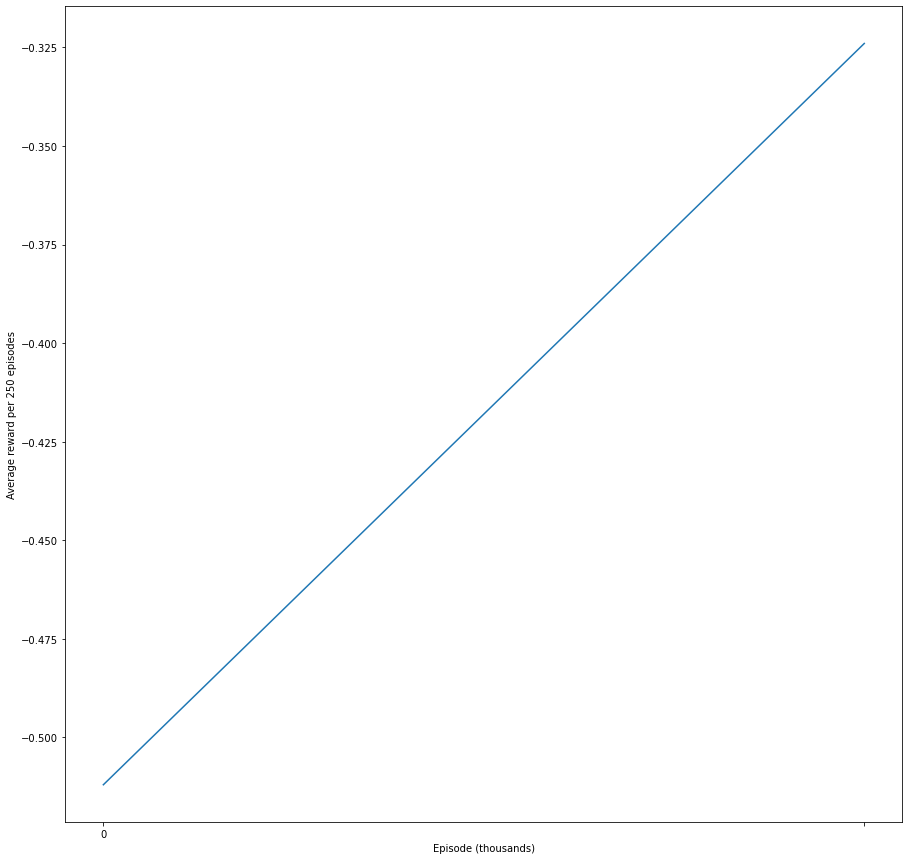

In [5]:
import matplotlib.pyplot as plt

q1_epsilon = 0.1 # Chosen because they use this in Q2 so this will allow us to nicely compare

q1_max_games = 500
q1_q_learnt_player = QLearntPlayer(env, _epsilon=q1_epsilon)
print_Q_val_with_moves(q1_q_learnt_player._Q_values)
q1_avgs = []
q1_rewards = []
q1_total_wins = 0

for game_epoch in range(q1_max_games//250):
    if game_epoch % 10 == 0:
        print('Game ', game_epoch*250, ' begins.')
    run_rewards = run_n_games(_max_games_number=250, _our_player=q1_q_learnt_player, _opponent_epsilon=0.5, \
            _our_player_new_game_epsilon=lambda game_number_n: q1_epsilon, _update_q_values=True)
    q1_rewards+=run_rewards
    q1_avgs.append(np.average(run_rewards))
    q1_total_wins += sum(1 if rew ==1 else 0 for rew in run_rewards)

print('Our agent won {} times'.format(q1_total_wins))
plt.figure(figsize=(15,15))
ax = plt.plot(q1_avgs)
plt.xticks(ticks=range(len(q1_avgs)), labels=[str(x*250 // 1000) if x*250 % 1000 == 0 else '' for x in range(len(q1_avgs))])
plt.ylabel('Average reward per 250 episodes')
plt.xlabel('Episode (thousands)')
plt.show()

In [6]:
_qv = q1_q_learnt_player._Q_values
print_Q_val_with_moves(_qv)

|- X X|
|O O X|
|O X O|

 {(0, 0): 0.05}
|X O O|
|O O X|
|X - X|

 {(2, 1): 0.0975}
|O X -|
|X O X|
|O O X|

 {(0, 2): 0.05}
|O X O|
|- X X|
|O O X|

 {(1, 0): 0.05}
|X X -|
|X O O|
|O X O|

 {(0, 2): 0.05}
|X - X|
|O O X|
|O X O|

 {(0, 1): 0.05}
|X X O|
|O - O|
|O X X|

 {(1, 1): 0.05}
|- O O|
|X X O|
|X O X|

 {(0, 0): 0.05}
|O O X|
|X X O|
|- X O|

 {(2, 0): 0.05}
|X O X|
|O X X|
|O O -|

 {(2, 2): 0.05}
|O X O|
|X X -|
|X O O|

 {(1, 2): 0.05}
|- X X|
|X O O|
|O X O|

 {(0, 0): 0.05}
|O X O|
|X O O|
|X X -|

 {(2, 2): 0.05}
|X X O|
|X O O|
|- O X|

 {(2, 0): 0.05}
|X O X|
|O - O|
|X X O|

 {(1, 1): 0.05}
|X O -|
|O O X|
|O X X|

 {(0, 2): 0.05}
|O O X|
|X O O|
|X X -|

 {(2, 2): 0.05}
|- O O|
|X O X|
|X X O|

 {(0, 0): 0.05}
|O O X|
|X O X|
|O X -|

 {(2, 2): 0.05}
|X X O|
|O X X|
|- - O|

 {(2, 0): -0.05, (2, 1): 0.0}
|X X O|
|O X X|
|- O -|

 {(2, 0): -0.05, (2, 2): 0}
|O O X|
|X X -|
|O X -|

 {(1, 2): 0, (2, 2): -0.05}
|X O O|
|X O X|
|- X -|

 {(2, 0): 0.05, (2, 2): 0}
|X O X

In [7]:
print_Q_val_with_moves(_qv, descending=True)

|- - -|
|- - -|
|- - -|

 {(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0.0, (1, 0): 0.0, (1, 1): 0.0, (1, 2): 0.0, (2, 0): 0.0, (2, 1): 0.006509134208027141, (2, 2): 0.0}
|X - -|
|- - -|
|- - -|

 {(0, 1): 0.0, (0, 2): 0.0005378958439417353, (1, 0): 0.0, (1, 1): 0.0, (1, 2): 0.0, (2, 0): 0.0, (2, 1): 0.0, (2, 2): 0.0}
|- - -|
|- O -|
|- X -|

 {(0, 0): 0.0, (0, 1): 0.0, (0, 2): 0, (1, 0): 0.0, (1, 2): 0.0, (2, 0): 0.019960596851871005, (2, 2): 0.0}
|- O -|
|X X -|
|- - -|

 {(0, 0): -0.05, (0, 2): -0.05, (1, 2): 0.0, (2, 0): 0, (2, 1): 0, (2, 2): 0.0}
|- - X|
|- - X|
|- O -|

 {(0, 0): -0.05, (0, 1): 0, (1, 0): 0, (1, 1): 0, (2, 0): 0, (2, 2): 0}
|X O -|
|- X -|
|- - -|

 {(0, 2): 0, (1, 0): 0, (1, 2): -0.05, (2, 0): 0, (2, 1): 0, (2, 2): 0.0}
|X - -|
|- X O|
|- - -|

 {(0, 1): 0, (0, 2): 0.0, (1, 0): 0.0, (2, 0): -0.05, (2, 1): 0, (2, 2): 0}
|- - X|
|- X -|
|- - O|

 {(0, 0): -0.05, (0, 1): 0.0, (1, 0): -0.05, (1, 2): 0, (2, 0): 0.0, (2, 1): 0.0}
|- - X|
|- X -|
|- O -|

 {(0, 0): 0, (0, 1): 0,

In [8]:
print_Q_val_with_moves(_qv, only_vals=3)

|O - -|
|- O X|
|O X X|

 {(0, 1): 0, (0, 2): 0.05, (1, 0): 0}
|X - -|
|O O -|
|X O X|

 {(0, 1): 0, (0, 2): -0.05, (1, 2): 0}
|O - -|
|X O -|
|X O X|

 {(0, 1): 0, (0, 2): -0.05, (1, 2): 0}
|X - X|
|- O X|
|- O O|

 {(0, 1): 0.05, (1, 0): -0.05, (2, 0): 0}
|X - O|
|O O -|
|X - X|

 {(0, 1): 0, (1, 2): 0, (2, 1): 0.05}
|O O X|
|X X -|
|- - O|

 {(1, 2): 0, (2, 0): 0.05, (2, 1): 0}
|O - O|
|- O X|
|X X -|

 {(0, 1): 0, (1, 0): 0, (2, 2): 0.05}
|O X X|
|X O -|
|O - -|

 {(1, 2): -0.05, (2, 1): -0.05, (2, 2): 0}
|X O X|
|- O -|
|O - X|

 {(1, 0): 0, (1, 2): 0.05, (2, 1): 0}
|- - -|
|X O O|
|X X O|

 {(0, 0): 0, (0, 1): -0.05, (0, 2): 0}
|O X X|
|- O X|
|- O -|

 {(1, 0): 0, (2, 0): -0.05, (2, 2): 0}
|- X O|
|X O X|
|- - O|

 {(0, 0): 0, (2, 0): 0, (2, 1): -0.05}
|O O -|
|O X -|
|X - X|

 {(0, 2): 0, (1, 2): 0, (2, 1): 0.05}
|O X -|
|X O -|
|X O -|

 {(0, 2): -0.05, (1, 2): 0, (2, 2): 0}
|O X X|
|X O O|
|- - -|

 {(2, 0): -0.05, (2, 1): 0, (2, 2): 0}
|X X O|
|- O O|
|- - X|

 {(1, 0): -0.0

Question 2. Plot average reward for every 250 games during training. Does decreasing epsilon help training
compared to having a fixed epsilon? What is the effect of n∗?
Expected answer: A figure showing average reward over time for different values of n∗ (caption length < 200 words)

Current n_star_q2 = 1.0
Game  0  begins.
Current n_star_q2 = 14.142135623730951
Game  0  begins.
Current n_star_q2 = 200.00000000000003
Game  0  begins.
Current n_star_q2 = 2828.4271247461907
Game  0  begins.
Current n_star_q2 = 40000.0
Game  0  begins.
won games per agent {1.0: 88, 14.142135623730951: 82, 200.00000000000003: 98, 2828.4271247461907: 79, 40000.0: 83}


Text(0, 0.5, 'Average q2_rewards per 250 epochs')

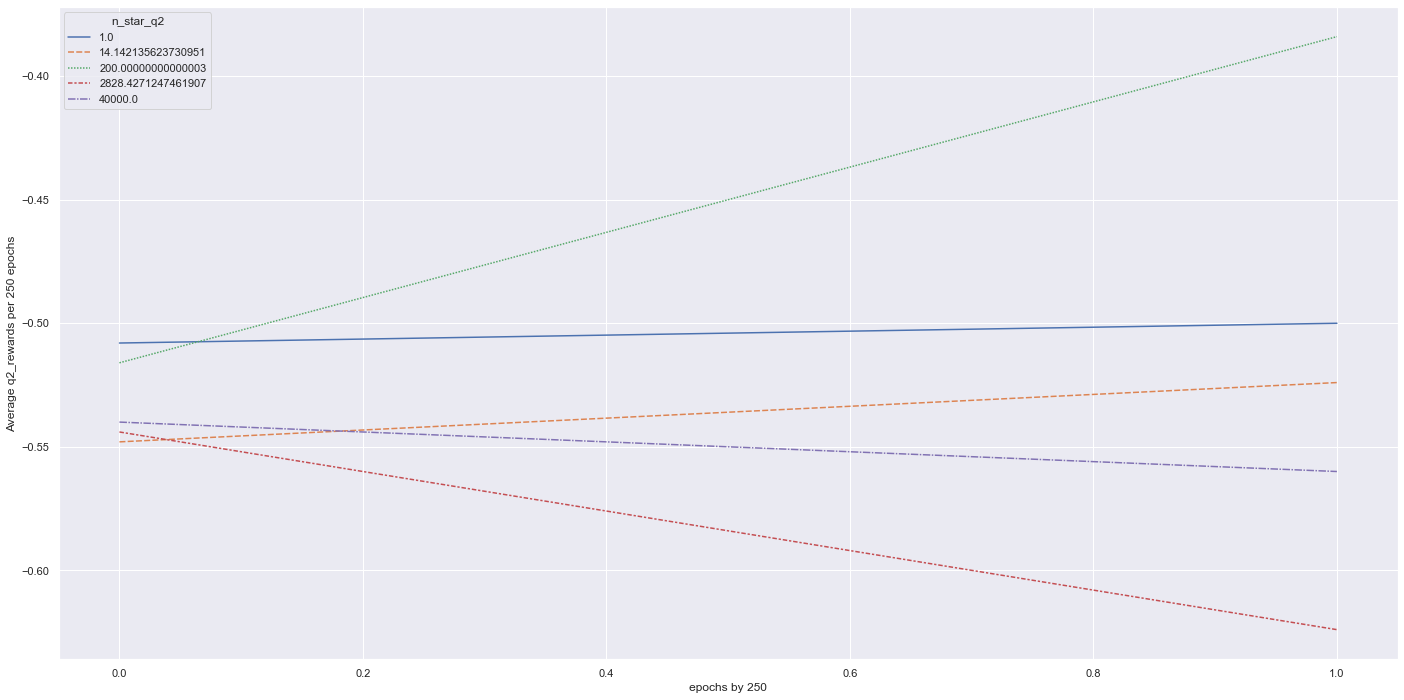

In [9]:
q2_max_games = 500
q2_n_stars =  np.geomspace(1, 40000, num=5) # Includes 1 and 40000
q2_epoch_size = 250
q2_rewards = {n_star_q2: [] for n_star_q2 in q2_n_stars}
q2_avgs = {n_star_q2: [] for n_star_q2 in q2_n_stars}
q2_M_opt = {n_star_q2: [] for n_star_q2 in q2_n_stars}
q2_M_rand = {n_star_q2: [] for n_star_q2 in q2_n_stars}
q2_total_wins = {n_star_q2: 0 for n_star_q2 in q2_n_stars}

q2_players = {}

q2_min_epsilon = 0.1
q2_max_epsilon = 0.8
def q2_calc_epsilon_factory(n_star_q2, epoch_size, game_epoch):
        def _calc_epsilon(game_number_n):
            real_game_number = game_epoch*q2_epoch_size + game_number_n
            return max(q2_min_epsilon, q2_max_epsilon*(1-(real_game_number/n_star_q2)))
        return _calc_epsilon

for n_star_q2 in q2_n_stars:
    # epsilons.append([])
    q2_starting_epsilon  = q2_calc_epsilon_factory(n_star_q2, q2_epoch_size, 0)(0)
    q2_q_learnt_player = QLearntPlayer(env, _epsilon=q2_starting_epsilon)
    q2_players[n_star_q2] = q2_q_learnt_player
    print('Current n_star_q2 = {}'.format(n_star_q2))

    for game_epoch in range(q2_max_games//q2_epoch_size):
        q2_calc_epsilon = q2_calc_epsilon_factory(n_star_q2=n_star_q2, epoch_size=q2_epoch_size, game_epoch=game_epoch)
        # print(game_epoch, q2_q_learnt_player._epsilon)
        if game_epoch % 20 == 0:
            print('Game ', game_epoch*q2_epoch_size, ' begins.')

        # Run 250 games with updating Q-vals and observe reward (exec 2)
        q2_run_rewards = run_n_games(_max_games_number=q2_epoch_size, _our_player=q2_q_learnt_player, _opponent_epsilon=0.5, \
            _our_player_new_game_epsilon=q2_calc_epsilon, _update_q_values=True)
        q2_avgs[n_star_q2].append(np.average(q2_run_rewards))
        q2_rewards[n_star_q2] += q2_run_rewards
        q2_total_wins[n_star_q2] += sum(1 if rew ==1 else 0 for rew in q2_run_rewards)

        # Run 500 games for M_opt calculation
        q2_M_opt_rewards = run_n_games(_max_games_number=500, _our_player=q2_q_learnt_player, _opponent_epsilon=0, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q2_M_opt[n_star_q2].append(np.average(q2_M_opt_rewards))


        # Run 500 games for M_rand calculation
        M_rand_rewards = run_n_games(_max_games_number=500, _our_player=q2_q_learnt_player, _opponent_epsilon=1, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q2_M_rand[n_star_q2].append(np.average(M_rand_rewards))

print('won games per agent', q2_total_wins)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# avgs = {n_star_q2: [] for n_star_q2 in q2_n_stars}
# for x in range(0,q2_max_games, 250):
#     lower_index = x
#     upper_index = min(x+250, q2_max_games-1)
#     for n_star_q2 in q2_n_stars:
#         slice = q2_rewards[n_star_q2][lower_index:upper_index]
#         avgs[n_star_q2].append(sum(slice)/len(slice))

q2_data = pd.DataFrame(q2_avgs)
q2_data.index.name = 'epochs by 250'
q2_data.transpose().index.name = 'n_star_q2'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q2_data)
g.set_ylabel('Average q2_rewards per 250 epochs')

# plt.figure(figsize=(15,15))
# ax = plt.plot(q2_avgs)
# plt.xticks(ticks=range(len(q2_avgs)), labels=[str(x*250 // 1000) if x*250 % 1000 == 0 else '' for x in range(len(avgs))])
# plt.ylabel('Average reward per 250 episodes')
# plt.xlabel('Episode (thousands)')
# plt.show()


In [10]:
q2_players[1.0]

In [11]:
pl = list(q2_players.values())

In [12]:
# DELETE

# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# avgs = {n_star: [] for n_star in n_stars}
# for x in range(0,max_games, 250):
#     lower_index = x
#     upper_index = min(x+250, max_games-1)
#     for n_star in n_stars:
#         slice = rewards[n_star][lower_index:upper_index]
#         avgs[n_star].append(sum(slice)/len(slice))

# q2_data = pd.DataFrame(avgs)
# q2_data.index.name = 'epochs by 250'
# q2_data.transpose().index.name = 'n_star'
# sns.set(rc={'figure.figsize':(24,12)})
# g = sns.lineplot(data=q2_data)
# g.set_ylabel('Average rewards per 250 epochs')

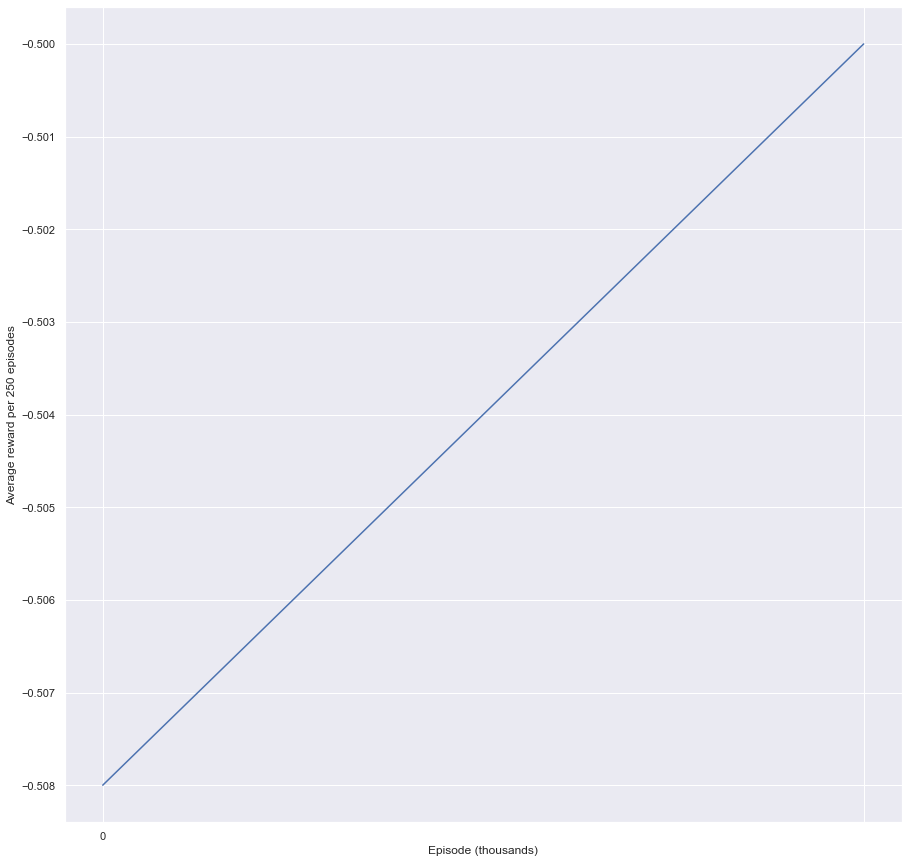

In [13]:
# Print the same plot as in exe 1 to ensure results are the same

plt.figure(figsize=(15,15))
ax = plt.plot(q2_avgs[1.0])
plt.xticks(ticks=range(len(q2_avgs[1.0])), labels=[str(x*250 // 1000) if x*250 % 1000 == 0 else '' for x in range(len(q2_avgs[1.0]))])
plt.ylabel('Average reward per 250 episodes')
plt.xlabel('Episode (thousands)')
plt.show()

In [14]:
for (n_star, rews) in q2_rewards.items():
    print('{} won {} games'.format(n_star, sum(1 if rew ==1 else 0 for rew in rews)))

1.0 won 88 games
14.142135623730951 won 82 games
200.00000000000003 won 98 games
2828.4271247461907 won 79 games
40000.0 won 83 games


In [15]:
len(q2_rewards[1.0])

500

#### Q2
*Does decreasing epsilon help with training compared to fix epsilon?*

(jl, April 22, 8:00pm)  **I cannot see a bug but it seems it virtually does not, which is very counterintuitive.** But the best value we seem to observe is when n_star = 1 but that is the same as not having any decrease at all and just hardcoding epsilon to 0.1. This is very strange indeed.


*What is the effect of n\*?*

Based on our small sample of 4 n*, it seems the smaller n* the better: n*=1 gets better perf than n*=34.2 which in turn gets better than n*=1169 which is in turn much better than n*=40,000.

Text(0, 0.5, 'M_opt')

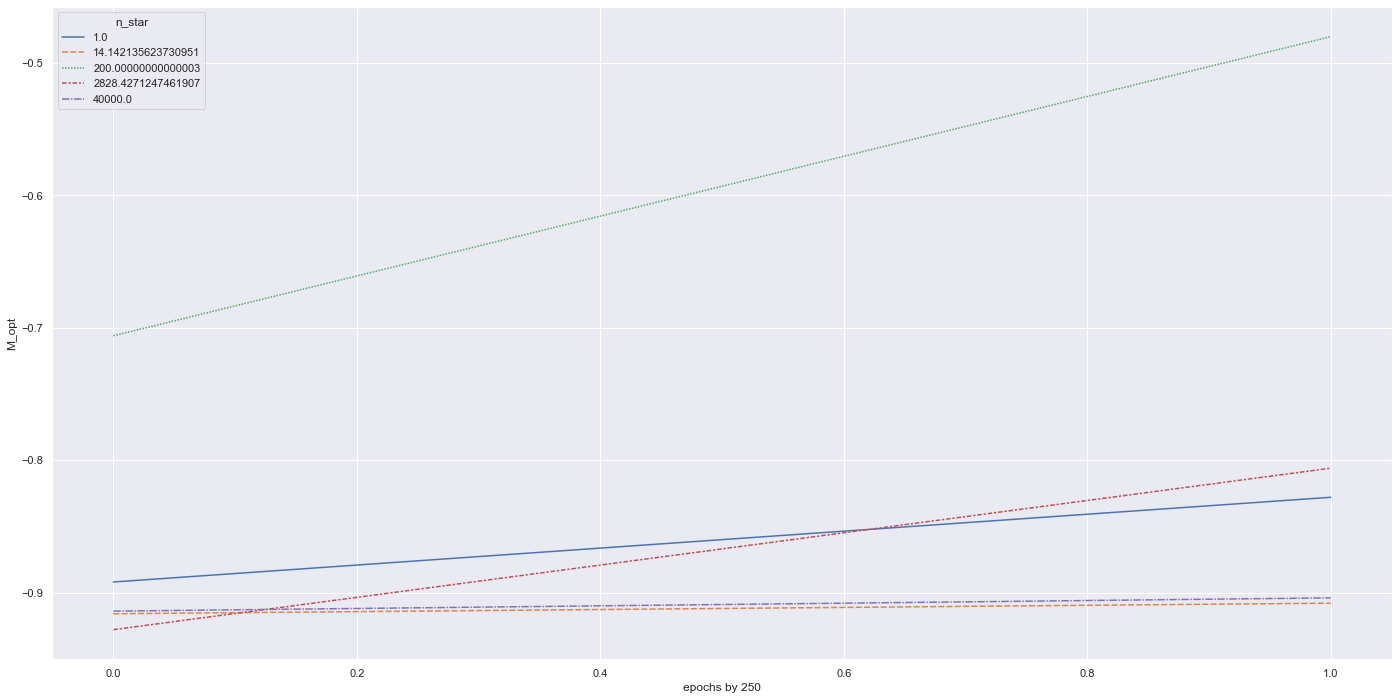

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

q2_M_opt_df = pd.DataFrame(q2_M_opt)
q2_M_opt_df.index.name = 'epochs by 250'
q2_M_opt_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q2_M_opt_df)
g.set_ylabel('M_opt')

Text(0, 0.5, 'q2_M_rand')

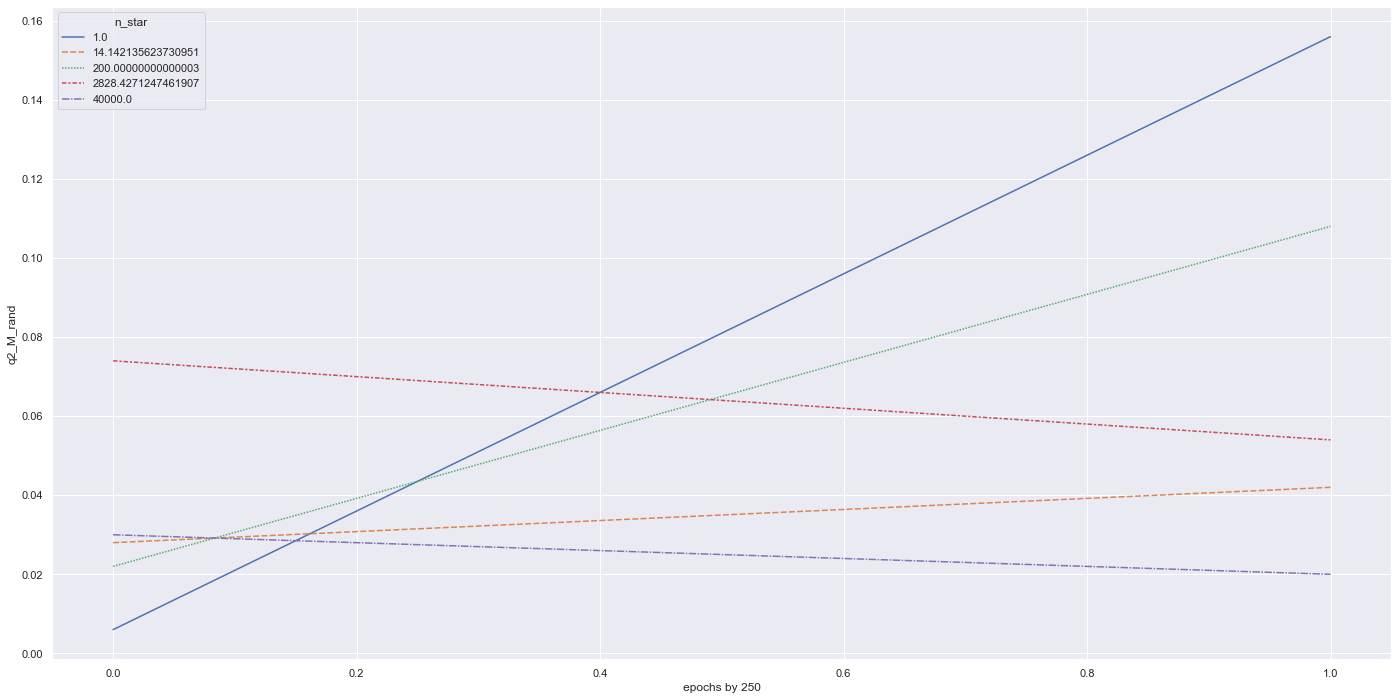

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

q2_M_rand_df = pd.DataFrame(q2_M_rand)
q2_M_rand_df.index.name = 'epochs by 250'
q2_M_rand_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q2_M_rand_df)
g.set_ylabel('q2_M_rand')

#### Q3
*Describe the differences and similarities between the curves and the one in the previous question*

Just like in the previous question, we can see lower values of n* significantly outperforming higher values

# Q4
Choose the best value of $n^∗$ that you found in the previous section. Run Q-learning against Opt($\epsilon_{opt}$) for
different values of $\epsilon_{opt}$ for 20’000 games – switch the 1st player after every game. Choose several values
of $\epsilon_{opt}$ from a reasonably wide interval between 0 to 1 – particularly, include $\epsilon_{opt}$ = 0.


Question 4. After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for your agents
– for each value of $\epsilon_{opt}$. Plot $M_{opt}$ and $M_{rand}$ over time. What do you observe? How can you explain it?
Expected answer: A figure showing $M_{opt}$ and $M_{rand}$ over time for different values of $\epsilon_{opt}$ (caption length
< 250 words).

In [18]:
best_n_star = 1

In [19]:
q4_max_games = 500
q4_epoch_size = 250

q4_eps_opts = np.linspace(0,1,num=5)

q4_rewards_eps = {eps_opt: [] for eps_opt in q4_eps_opts}
q4_M_opt_eps = {eps_opt: [] for eps_opt in q4_eps_opts}
q4_M_rand_eps = {eps_opt: [] for eps_opt in q4_eps_opts}

q4_min_epsilon = 0.1
q4_max_epsilon = 0.8


def q4_calc_epsilon_factory_eps(epoch_size, game_epoch):
        def _calc_epsilon(game_number_n):
            real_game_number = game_epoch*epoch_size + game_number_n
            return max(q4_min_epsilon, q4_max_epsilon*(1-(real_game_number/best_n_star)))
        return _calc_epsilon

for eps_opt in q4_eps_opts:
    q4_starting_epsilon  = q4_calc_epsilon_factory_eps(q4_epoch_size, 0)(0)
    q4_q_learnt_player = QLearntPlayer(env, _epsilon=q4_starting_epsilon)
    print('Current eps_opt = {}'.format(eps_opt))

    for game_epoch in range(q4_max_games//q4_epoch_size):
        q4_calc_epsilon = q4_calc_epsilon_factory_eps(epoch_size=q4_epoch_size, game_epoch=game_epoch)
        if game_epoch % 20 == 0:
            print('Game ', game_epoch*q4_epoch_size, ' begins.')

        # Run 250 games with updating Q-vals and observe reward (exec 4)
        q4_run_rewards = run_n_games(_max_games_number=q4_epoch_size, _our_player=q4_q_learnt_player, _opponent_epsilon=eps_opt, \
            _our_player_new_game_epsilon=q4_calc_epsilon, _update_q_values=True)
        q4_rewards_eps[eps_opt] += q4_run_rewards

        # Run 500 games for q4_M_opt_eps calculation
        q4_M_opt_eps_rewards = run_n_games(_max_games_number=500, _our_player=q4_q_learnt_player, _opponent_epsilon=0, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q4_M_opt_eps[eps_opt].append(np.average(q4_M_opt_eps_rewards))


        # Run 500 games for q4_M_rand_eps calculation
        q4_M_rand_eps_rewards = run_n_games(_max_games_number=500, _our_player=q4_q_learnt_player, _opponent_epsilon=1, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q4_M_rand_eps[eps_opt].append(np.average(q4_M_rand_eps_rewards))


Current eps_opt = 0.0
Game  0  begins.
Current eps_opt = 0.25
Game  0  begins.
Current eps_opt = 0.5
Game  0  begins.
Current eps_opt = 0.75
Game  0  begins.
Current eps_opt = 1.0
Game  0  begins.


Text(0, 0.5, 'M_opt_eps')

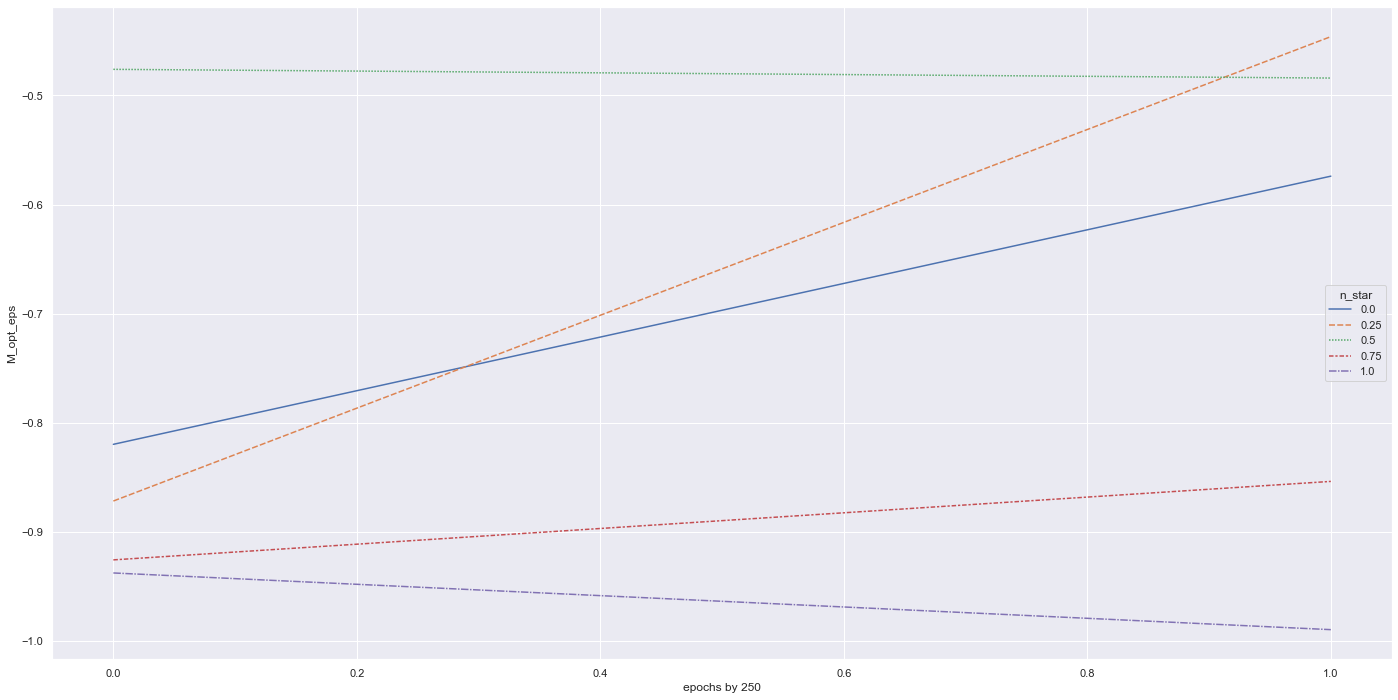

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

q4_M_opt_eps_df = pd.DataFrame(q4_M_opt_eps)
q4_M_opt_eps_df.index.name = 'epochs by 250'
q4_M_opt_eps_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q4_M_opt_eps_df)
g.set_ylabel('M_opt_eps')

(jl, April 22, 8:00pm) **I think most likely there must be a bug** because it seems quite strange that the eps=0 option would learn to play the opponent perfectly right away after only 250 epochs. I can't remember anymore, but I don't think that is what we observed before? Definitely something to check. Also it seems weird to me that the process is not monotone. Would we not expect to only improve? How come we suddenly get worse? I guess there is some variance due to our epsilon (i.e. sometimes we explore and we don't choose the perfect option) so maybe that explains it?

**EDIT (10pm)**: Maybe the reason why it underperforms against random player is that since its trained against a perfect player, it learns quickly how to almost perfectly avoid losses, but it never learns how to achieve wins since it never gets a chance to do that during training – hence it continues to play those positions randomly. **So perhaps this is not a bug afterall.** Still it does not make sense though why performance of 0.25 is bad against rand when it's so good here – 0.25 already gets exposure to winning positions so it should perform well? After 20k games I'd think it would have a chance to see winning positions often enough but perhaps I'm wrong.

# Q5
What are the highest values of $M_{opt}$ and $M_{rand}$ that you could achieve after playing 20’000 games?

The highest value of $M_{opt}$ is achieved by $\epsilon=0.0$ and $\epsilon=0.25$ and it is the value 0 which is the best that we can hope for against  $M_{opt}$. The highest value of $M_{rand}$ is near $0.8$ achieved by  $\epsilon=0.75$ 



In [21]:
q4_M_opt_eps_df

n_star,0.00,0.25,0.50,0.75,1.00
epochs by 250,,,,,
0,-0.820,-0.872,-0.476,-0.926,-0.938
1,-0.574,-0.446,-0.484,-0.854,-0.990


Text(0, 0.5, 'M_rand_eps')

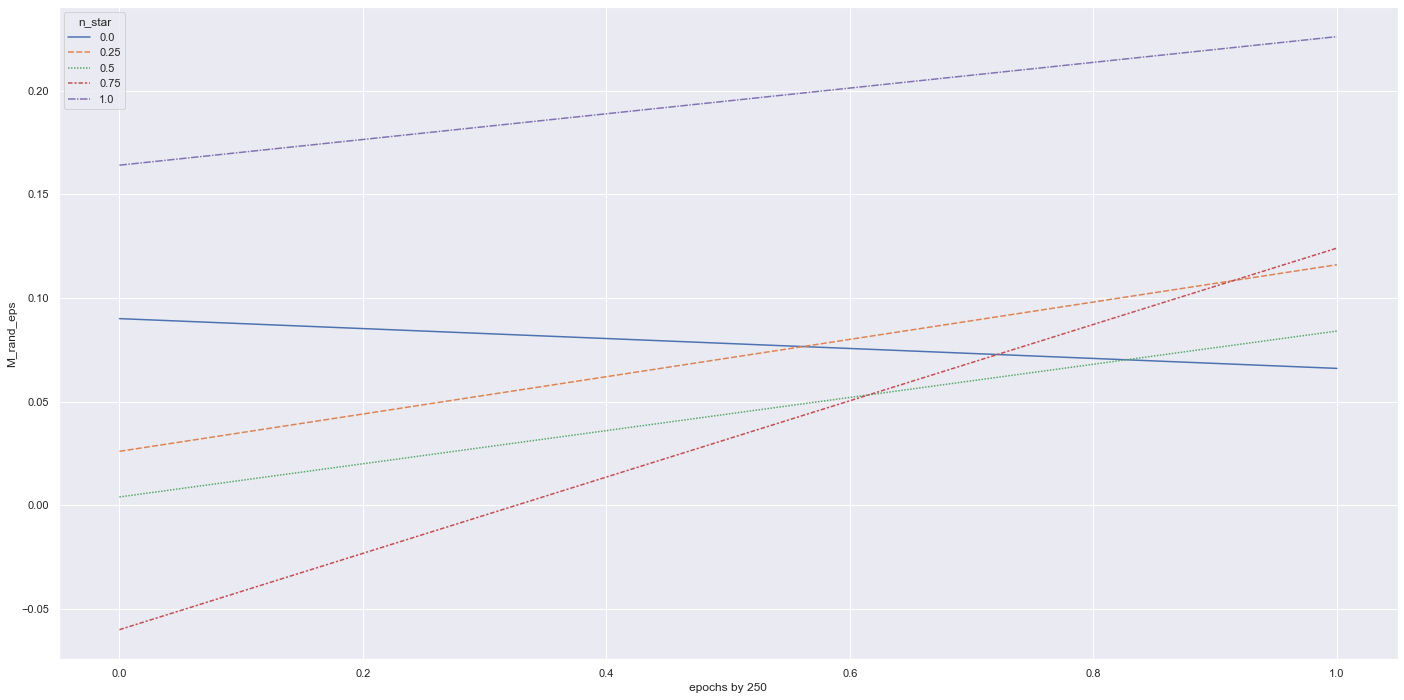

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

q4_M_rand_eps_df = pd.DataFrame(q4_M_rand_eps)
q4_M_rand_eps_df.index.name = 'epochs by 250'
q4_M_rand_eps_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q4_M_rand_eps_df)
g.set_ylabel('M_rand_eps')

**Again** it is super weird that the M_rand plot is not a mirror image of the M_opt; i.e. we'd expect that if 0.0 gets great performance again M_opt, it should get great performance here. This is not what seems to be happening though.

# Q6 (answer)
*Question 6. (Theory) Assume that Agent 1 learns by playing against $\text{Opt}(0)$ and find the optimal Q-
values $Q_1(s, a)$. In addition, assume that Agent 2 learns by playing against $\text{Opt}(1)$ and find the optimal
Q-values $Q_2(s, a)$. Do $Q_1(s, a)$ and $Q_2(s, a)$ have the same values? Justify your answer. (answer length
< 150 words)*

No, they will not have the same values. This is because if we play an optimal agent, we will never win and thus never observe a positive reward. Therefore all Q-values will be at best 0. However, playing against a random oponent, we will definitely win sometimes and as we will get closer and closer to convergence, we will play better and better and win more and more. We will therefore definitely observe positive rewards at times. Hence, the Q-values will be different.

# 2.2 Learning by practice
In this section, your are supposed to ask whether Q-learning can learn to play Tic Tac Toe by only
playing against itself. For different values of $\epsilon \in [0, 1)$, run a Q-learning agent against itself for 20’000
games – i.e. both players use the same set of Q-values and update the same set of Q-values.



# Q7 (code below)
*Question 7. After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for different
values of $\epsilon \in [0, 1)$. Does the agent learn to play Tic Tac Toe? What is the effect of $\epsilon$?
Expected answer: A figure showing $M_{opt}$ and $M_{rand}$ over time for different values of $\epsilon \in [0, 1)$ (caption
length < 100 words).*

In [23]:
def run_n_games_against_self(_max_games_number, _our_player, _our_player_new_game_epsilon, _update_q_values, _progress_print=None):
    _rewards = {'our_player': [None for _ in range(_max_games_number)],'opponent': [None for _ in range(_max_games_number)]}
    _turns = ['X','O']
    opponent = QLearntPlayer(_our_player._game_env, _our_player._epsilon,_our_player._discount_rate_gamma, _our_player._learning_rate_alpha)

    # Ensure they share Q_values... I think this should work but it seems (as of April 22, 8pm)
    # that there is a bug: see more below
    opponent._Q_values = _our_player._Q_values


    for game in range(_max_games_number):
        if _progress_print and game % _progress_print == 0:
            print('Game ', game, ' begins.')
        env.reset()
        grid, _, __ = env.observe()
        _turns = _turns[::-1] # Reverse after every game to ensure both sides played equally
        opponent = opponent.prepare_new_game_(_turns[0])
        _our_player = _our_player.prepare_new_game_(_turns[1])
        assert opponent._player != _our_player._player
        _our_player._epsilon = _our_player_new_game_epsilon(game_number_n=game)
        opponent._epsilon = _our_player_new_game_epsilon(game_number_n=game)

        for turn in range(9):
            opponent_turn = env.current_player == opponent._player
            if opponent_turn:
                chosen_move = opponent.choose_move_(grid)
            else:
                chosen_move = _our_player.choose_move_(grid)

            grid, end, winner = env.step(chosen_move, print_grid=False)

            if end:
                _update_q_values and _our_player.update_q_values_(grid, game_over = end)
                _update_q_values and opponent.update_q_values_(grid, game_over = end)
                _rewards['our_player'][game] = env.reward(_our_player._player)
                _rewards['opponent'][game] = env.reward(opponent._player)
                break
            else:
                if opponent_turn:
                    turn!=0 and _update_q_values and _our_player.update_q_values_(grid, game_over = end)
                else:
                    turn!=0 and _update_q_values and opponent.update_q_values_(grid, game_over = end)

    return _rewards

In [24]:
q7_max_games = 500
q7_epoch_size = 250

q7_eps_selfs = np.linspace(0,0.99,num=5)

q7_M_opt_self = {eps_opt: [] for eps_opt in q7_eps_selfs}
q7_M_rand_self = {eps_opt: [] for eps_opt in q7_eps_selfs}

q7_min_epsilon = 0.1
q7_max_epsilon = 0.8

n_star = None
calc_epsilon = None

for eps_s in q7_eps_selfs:
    q7_q_learnt_player = QLearntPlayer(env, _epsilon=q7_min_epsilon)
    print('Current eps_s = {}'.format(eps_s))

    for game_epoch in range(q7_max_games//q7_epoch_size):
        q7_calc_epsilon = lambda game_number_n: eps_s
        if game_epoch % 20 == 0:
            print('Game ', game_epoch*q7_epoch_size, ' begins.')

        # Run 250 games with updating Q-vals and observe reward (exec 7)
        run_rewards = run_n_games_against_self(_max_games_number=q7_epoch_size, _our_player=q7_q_learnt_player, \
            _our_player_new_game_epsilon=q7_calc_epsilon, _update_q_values=True)

        # Run 500 games for q7_M_opt_self calculation
        q7_M_opt_self_rewards = run_n_games(_max_games_number=500, _our_player=q7_q_learnt_player, _opponent_epsilon=0, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q7_M_opt_self[eps_s].append(np.average(q7_M_opt_self_rewards))


        # Run 500 games for q7_M_rand_self calculation
        q7_M_rand_self_rewards = run_n_games(_max_games_number=500, _our_player=q7_q_learnt_player, _opponent_epsilon=1, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q7_M_rand_self[eps_s].append(np.average(q7_M_rand_self_rewards))


Current eps_s = 0.0
Game  0  begins.
Current eps_s = 0.2475
Game  0  begins.
Current eps_s = 0.495
Game  0  begins.
Current eps_s = 0.7424999999999999
Game  0  begins.
Current eps_s = 0.99
Game  0  begins.


Text(0, 0.5, 'q7_M_opt_self')

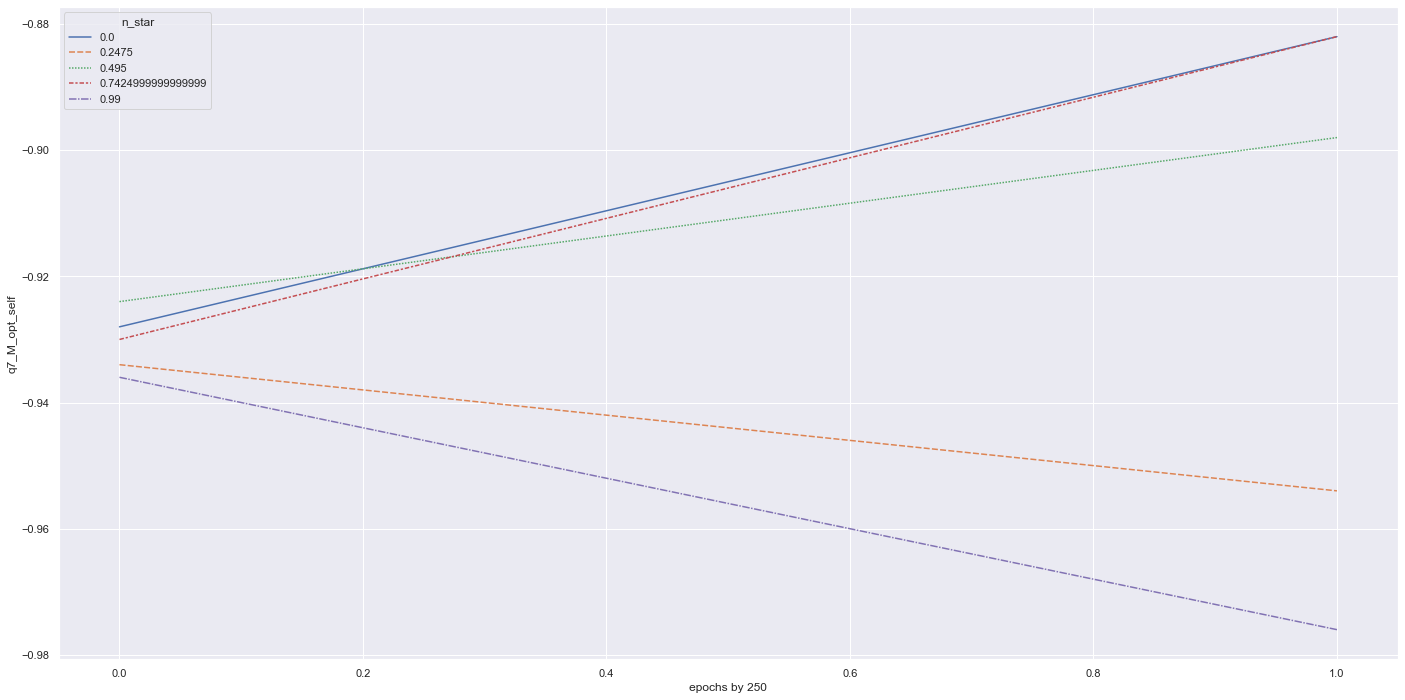

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

q7_M_opt_self_df = pd.DataFrame(q7_M_opt_self)
q7_M_opt_self_df.index.name = 'epochs by 250'
q7_M_opt_self_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q7_M_opt_self_df)
g.set_ylabel('q7_M_opt_self')

Text(0, 0.5, 'q7_M_opt_self')

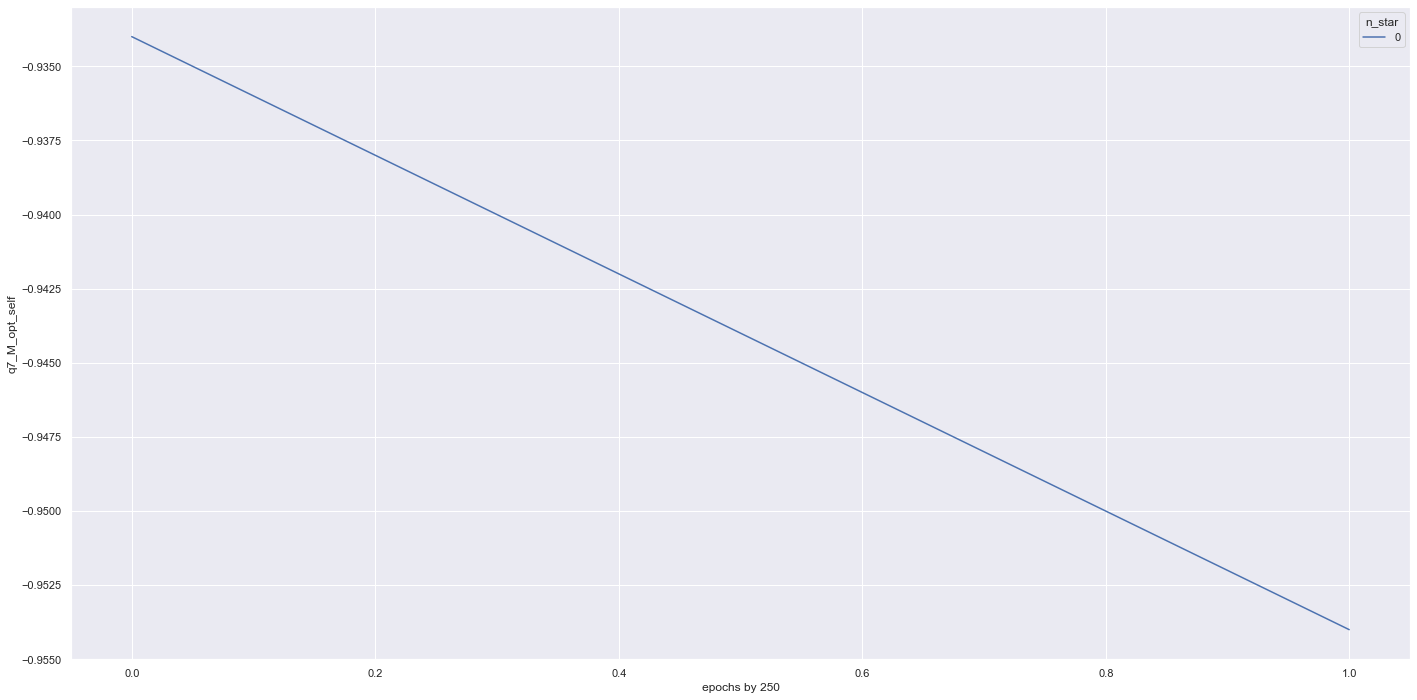

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

q7_M_opt_self_df = pd.DataFrame(q7_M_opt_self[q7_eps_selfs[1]])
q7_M_opt_self_df.index.name = 'epochs by 250'
q7_M_opt_self_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q7_M_opt_self_df)
g.set_ylabel('q7_M_opt_self')

Text(0, 0.5, 'q7_M_rand_self')

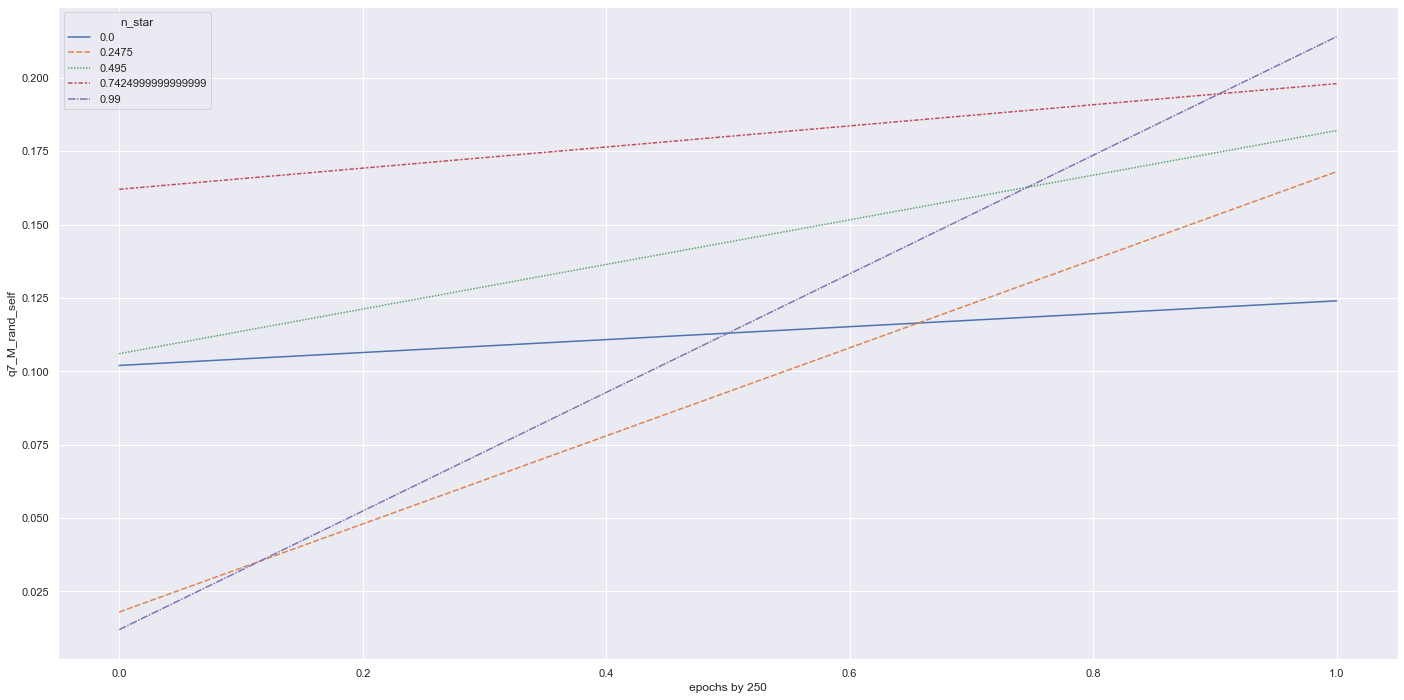

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

q7_M_rand_self_df = pd.DataFrame(q7_M_rand_self)
q7_M_rand_self_df.index.name = 'epochs by 250'
q7_M_rand_self_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q7_M_rand_self_df)
g.set_ylabel('q7_M_rand_self')

# Q7 (answer)
*Question 7. After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for different
values of $\epsilon \in [0, 1)$. Does the agent learn to play Tic Tac Toe? What is the effect of $\epsilon$?
Expected answer: A figure showing $M_{opt}$ and $M_{rand}$ over time for different values of $\epsilon \in [0, 1)$ (caption
length < 100 words).*

(jl, April 22 8:00 pm) **It seems that there is some bug here** because very little learning seems to be going on. I would expect the agent here to learn at least as well as when playing a random oponent.

# Q8 (code below)
For rest of this section, use $\epsilon(n)$ in Equation 1 with different values of $n^∗$ – instead of fixing $\epsilon$.
Question 8. After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for your agents.
Does decreasing $\epsilon$ help training compared to having a fixed $\epsilon$? What is the effect of $n^∗$?
Expected answer: A figure showing $M_{opt}$ and $M_{rand}$ over time for different values of speeds of $n^∗$ (caption
length < 100 words).

In [28]:
q8_max_games = 500
q8_n_stars =  np.geomspace(1, 40000, num=4) # Includes 1 and 40000
epoch_size = 250

q8_rewards_self_n_stars = {n_star_q8: {'our_player': [], 'opponent':[]} for n_star_q8 in q8_n_stars}
q8_M_opt_self_n_stars = {n_star_q8: [] for n_star_q8 in q8_n_stars}
q8_M_rand_self_n_stars = {n_star_q8: [] for n_star_q8 in q8_n_stars}

q8_min_epsilon = 0.1
q8_max_epsilon = 0.8
def q8_calc_epsilon_factory(n_star_q8, epoch_size, game_epoch):
        def _calc_epsilon(game_number_n):
            real_game_number = game_epoch*epoch_size + game_number_n
            return max(q8_min_epsilon, q8_max_epsilon*(1-(real_game_number/n_star_q8)))
        return _calc_epsilon

for n_star_q8 in q8_n_stars:
    q8_q_learnt_player = QLearntPlayer(env, _epsilon=q8_max_epsilon)
    print('Current n_star_q8 = {}'.format(n_star_q8))

    for game_epoch in range(q8_max_games//epoch_size):
        q8_calc_epsilon = q8_calc_epsilon_factory(n_star_q8=n_star_q8, epoch_size=epoch_size, game_epoch=game_epoch)
        if game_epoch % 20 == 0:
            print('Game ', game_epoch*epoch_size, ' begins.')

        # Run 250 games with updating Q-vals and observe reward (exec 8)
        run_rewards = run_n_games_against_self(_max_games_number=epoch_size, _our_player=q8_q_learnt_player, \
            _our_player_new_game_epsilon=q8_calc_epsilon, _update_q_values=True)
        q8_rewards_self_n_stars[n_star_q8]['our_player'] += run_rewards['our_player']
        q8_rewards_self_n_stars[n_star_q8]['opponent'] += run_rewards['opponent']

        # Run 500 games for q8_M_opt_self_n_stars calculation
        q8_M_opt_self_n_stars_rewards = run_n_games(_max_games_number=500, _our_player=q8_q_learnt_player, _opponent_epsilon=0, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q8_M_opt_self_n_stars[n_star_q8].append(np.average(q8_M_opt_self_n_stars_rewards))


        # Run 500 games for q8_M_rand_self_n_stars calculation
        q8_M_rand_self_n_stars_rewards = run_n_games(_max_games_number=500, _our_player=q8_q_learnt_player, _opponent_epsilon=1, \
            _our_player_new_game_epsilon=lambda game_number_n: 0, _update_q_values=False)
        q8_M_rand_self_n_stars[n_star_q8].append(np.average(q8_M_rand_self_n_stars_rewards))



Current n_star_q8 = 1.0
Game  0  begins.
Current n_star_q8 = 34.19951893353395
Game  0  begins.
Current n_star_q8 = 1169.6070952851471
Game  0  begins.
Current n_star_q8 = 40000.0
Game  0  begins.


Text(0, 0.5, 'q8_M_rand_self_n_stars')

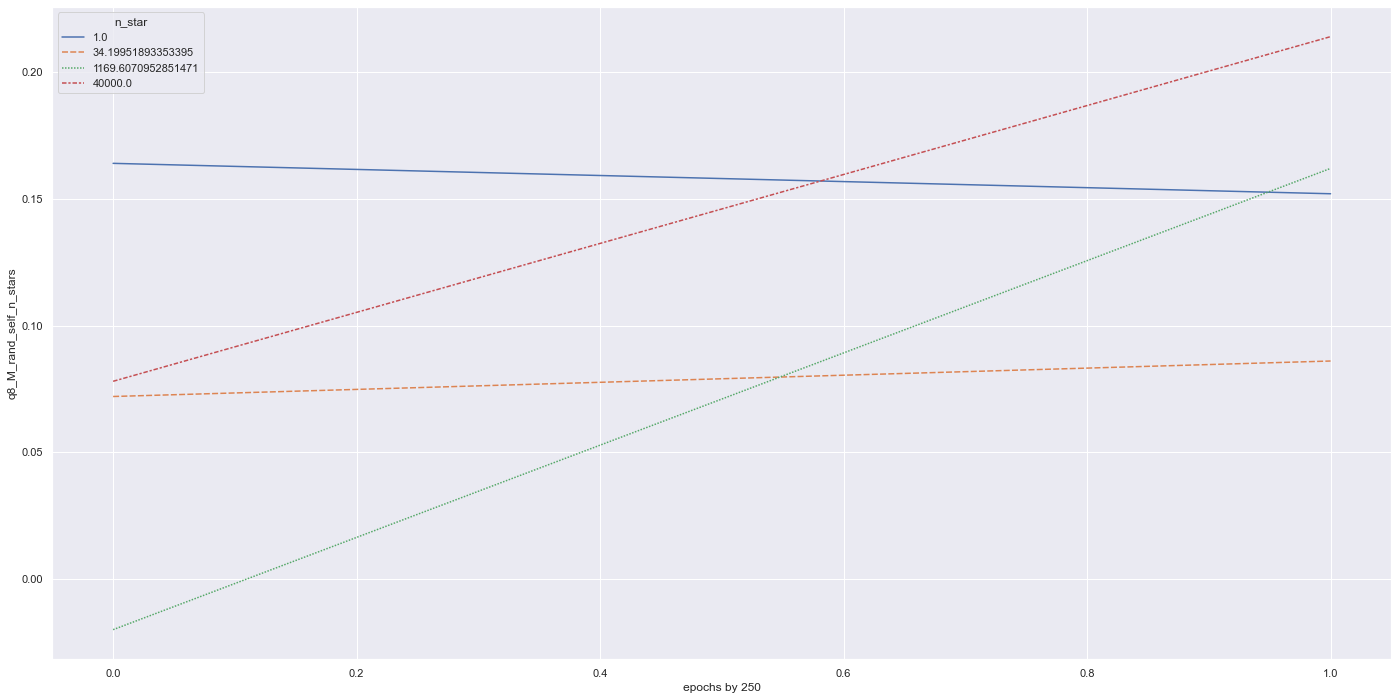

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

q8_M_rand_self_n_stars_df = pd.DataFrame(q8_M_rand_self_n_stars)
q8_M_rand_self_n_stars_df.index.name = 'epochs by 250'
q8_M_rand_self_n_stars_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q8_M_rand_self_n_stars_df)
g.set_ylabel('q8_M_rand_self_n_stars')

Text(0, 0.5, 'q8_M_opt_self_n_stars')

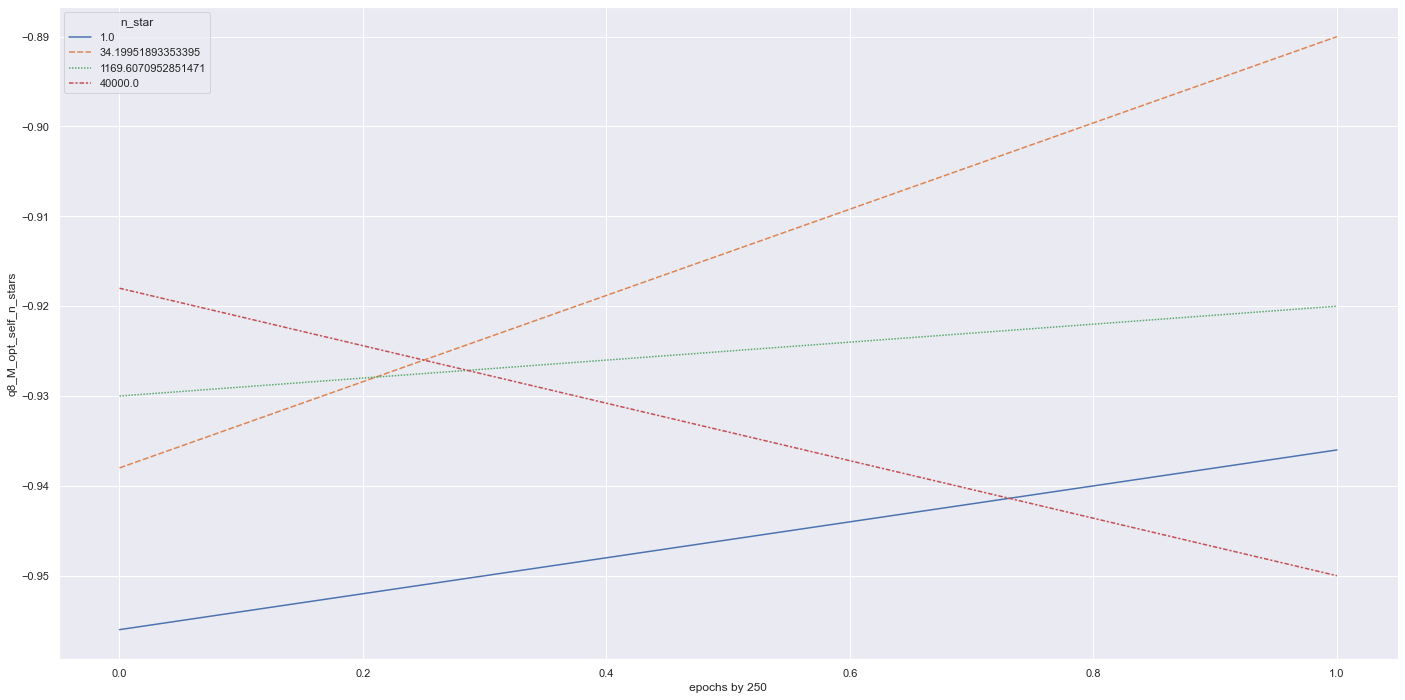

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

q8_M_opt_self_n_stars_df = pd.DataFrame(q8_M_opt_self_n_stars)
q8_M_opt_self_n_stars_df.index.name = 'epochs by 250'
q8_M_opt_self_n_stars_df.transpose().index.name = 'n_star'
sns.set(rc={'figure.figsize':(24,12)})
g = sns.lineplot(data=q8_M_opt_self_n_stars_df)
g.set_ylabel('q8_M_opt_self_n_stars')

# Q8 (answer)
For rest of this section, use $\epsilon(n)$ in Equation 1 with different values of $n^∗$ – instead of fixing $\epsilon$.
Question 8. After every 250 games during training, compute the ‘test’ $M_{opt}$ and $M_{rand}$ for your agents.
Does decreasing $\epsilon$ help training compared to having a fixed $\epsilon$? What is the effect of $n^∗$?
Expected answer: A figure showing $M_{opt}$ and $M_{rand}$ over time for different values of speeds of $n^∗$ (caption
length < 100 words).

(jl, April 22 8:00 pm) **Just like in Q7, I think this is buggy** because very little learning seems to be going on. I would expect the agent here to learn at least as well as when playing a random oponent.

# Q9
*Question 9. What are the highest values of $M_{opt}$ and $M_{rand}$ that you could achieve after playing 20’000 games?*

**TODO: Answer once sure the above code is not buggy**

# Q10
*Question 10. For three board arrangements (i.e. states s), visualize Q-values of available actions (e.g.
using heat maps). Does the result make sense? Did the agent learn the game well?
Expected answer: A figure with 3 subplots of 3 different states with Q-values shown at available actions
(caption length < 200 words).*

**TODO: Answer once sure the above code is not buggy**

# 3 Deep Q-Learning
As our 2nd algorithm, we use Deep Q-Learning (DQN) combined with $\epsilon$-greedy policy. You can watch
again Part 1 of Deep Reinforcement Learning Lecture 1 for an introduction to DQN and Part 1 of
Deep Reinforcement Learning Lecture 2 (in particular slide 8) for more details. The idea in DQN is
to approximate Q-values by a neural network instead of a look-up table as in Tabular Q-learning. For
implementation, you can use ideas from the DQN tutorials of Keras and PyTorch.

# 3.2 Learning from experts
Implement the DQN algorithm. To check the algorithm, run a DQN agent with a fixed and arbitrary
$\epsilon \in [0,1)$ against Opt(0.5) for 20’000 games – switch the 1st player after every game.

## Question 11
*Plot average reward and average training loss for every 250 games during training. Does
the loss decrease? Does the agent learn to play Tic Tac Toe?
Expected answer: A figure with two subplots (caption length $<$ 50 words). Specify your choice of $\epsilon$.*

**Answer:** We use $\epsilon = 0.05$ as that is the value that Mnih at el (2015) use.

In [31]:
import torch
from torch import nn
from torch.nn import functional as F
from torchsummary import summary 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def state_to_torch(game_state: np.ndarray):
    return torch.cat((torch.from_numpy((game_state == 1).astype(int)).view(3,3,1), torch.from_numpy((game_state == -1).astype(int)).view(3,3,1)), dim=2).to(device)

def game_state_converts_to_pytorch_correctly():
    game_state = np.array([ [ 1.,  1.,  1.], \
                            [ 1.,  0., -1.], \
                            [-1., -1.,  1.]])
    torch_repre = state_to_torch(game_state)
    expected_our_positions = torch.from_numpy((game_state==1).astype(int))
    torch_repre_our_positions = torch_repre[:,:,0]
    assert (expected_our_positions == torch_repre_our_positions).all()
    expected_opponent_positions = torch.from_numpy((game_state==-1).astype(int))
    torch_repre_opponent_positions = torch_repre[:,:,1]
    assert (expected_opponent_positions == torch_repre_opponent_positions).all()
    return True

assert game_state_converts_to_pytorch_correctly()

In [32]:
# This cell's code is taken from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html?highlight=huber

from collections import namedtuple, deque
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [33]:
class DQNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net =  nn.Sequential(
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(9))

    def forward(self, inp):
        input_in_1D = inp.view(inp.size(0), -1)
        return self.net(input_in_1D)

summary(DQNet().to(device), (3,3,2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           2,432
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
            Linear-5                    [-1, 9]           1,161
Total params: 20,105
Trainable params: 20,105
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


/usr/local/Caskroom/miniconda/base/envs/dl-practicals/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [34]:
class DQN_Player(BasePlayer):
    def __init__(self):
        self.model = DQNet()
        LEARNING_RATE = 5 * 10e-4 # Given in the instructions PDF
        DISCOUNT_RATE_GAMMA = 0.99
        BATCH_SIZE = 64
        BUFFER_SIZE = 10_000
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.criterion = nn.SmoothL1Loss() # "When delta is set to 1, this loss is equivalent to SmoothL1Loss." (PyTorch HuberLoss documentation)

    def choose_move(self, grid, epsilon):
        possible_moves
        if random.random() > 



SyntaxError: invalid syntax (2886656077.py, line 13)

In [ ]:
(x == 1).astype(int), (x == -1).astype(int)

(array([[1, 1, 1],
        [1, 0, 0],
        [0, 0, 1]]),
 array([[0, 0, 0],
        [0, 1, 1],
        [1, 1, 0]]))

In [ ]:
y = torch.cat((torch.from_numpy((x == 1).astype(int)).view(3,3,1), torch.from_numpy((x == -1).astype(int)).view(3,3,1)), dim=2)
y

tensor([[[1, 0],
         [1, 0],
         [1, 0]],

        [[1, 0],
         [0, 1],
         [0, 1]],

        [[0, 1],
         [0, 1],
         [1, 0]]])

In [ ]:
y[:,:,0], y[:,:,1]

(tensor([[1, 1, 1],
         [1, 0, 0],
         [0, 0, 1]]),
 tensor([[0, 0, 0],
         [0, 1, 1],
         [1, 1, 0]]))

In [ ]:
(y[:,:,0] == torch.from_numpy((x==1).astype(int))).all()

tensor(True)